In [1]:

%pylab inline
#%matplotlib notebook

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys,os
sys.path.append('..')
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam, OptParamArray
from backtester.swarms.ranking import SwarmRanker
from backtester.swarms.rebalancing import SwarmRebalance
from backtester.swarms.filters import SwarmFilter
from backtester.costs import CostsManagerEXOFixed
from backtester.exoinfo import EXOInfo
from backtester.swarms.rankingclasses import *
from backtester.swarms.swarm import Swarm

In [3]:
import cufflinks as cf
cf.go_offline()

import pandas as pd
import numpy as np
import scipy
import seaborn as sn
# import seaborn as sns
sn.set_style('dark')

In [4]:
from scripts.settings import *
try:
    from scripts.settings_local import *
except:
    pass

from exobuilder.data.exostorage import EXOStorage

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)


exo_filter = '_ContFut'     # All 
#exo_filter = '_Bi_'  # ES only
#exo_filter = 'ES*Collar'  # ES Collars (incl Bearish, Bullish, BW and vanilla)

# [print(exo) for exo in storage.exo_list(exo_filter)];

In [5]:
from sklearn import (pipeline, preprocessing, ensemble, neighbors, model_selection)
from scipy import signal, ndimage

class Strategy_DSP_LPBP_Combination(StrategyBase):
    name = 'Strategy_DSP_LPBP_Combination'


    def __init__(self, strategy_context):
        # Initialize parent class
        super().__init__(strategy_context)
   
    def calc_entryexit_rules(self, lp_order, lp_freq, bp_order, bp_startfreq, bp_stopfreq, bp_multiplier, rule_index):
        px_ser = self.data.exo
        
        b, a = signal.butter(lp_order, lp_freq, btype='lowpass')
    
        lpfilt = px_ser.copy()
        lpfilt.values[:] = signal.lfilter(b, a, lpfilt) 
        
        b, a = signal.butter(bp_order, [bp_startfreq, bp_stopfreq], btype='bandpass')
    
        bpfilt = px_ser.copy()
        bpfilt.values[:] = signal.lfilter(b, a, bpfilt) 
        
        lpbp = lpfilt - bpfilt*bp_multiplier
        
        if rule_index == 0: 
            entry_rule = CrossDown(lpbp, px_ser)
            exit_rule = CrossUp(lpbp, px_ser)

            return entry_rule, exit_rule
        
        elif rule_index == 1: 
            entry_rule = CrossUp(lpbp, px_ser)
            exit_rule = CrossDown(lpbp, px_ser)

            return entry_rule, exit_rule
        
        elif rule_index == 2: 
            entry_rule = lpbp > lpfilt
            exit_rule = lpbp < lpfilt

            return entry_rule, exit_rule

        elif rule_index == 3: 
            entry_rule = lpbp < lpfilt
            exit_rule = lpbp > lpfilt

            return entry_rule, exit_rule
            
    def calculate(self, params=None, save_info=False):
    #
    #
    #  Params is a tripple like (50, 10, 15), where:
    #   50 - slow MA period
    #   10 - fast MA period
    #   15 - median period
    #
    #  On every iteration of swarming algorithm, parameter set will be different.
    #  For more information look inside: /notebooks/tmp/Swarming engine research.ipynb
    #

        if params is None:
            # Return default parameters
            (direction, lp_order, lp_freq, bp_order, bp_startfreq, bp_stopfreq, bp_multiplier, rule_index) = self.default_opts()
        else:
            # Unpacking optimization params
            #  in order in self.opts definition
            (direction, lp_order, lp_freq, bp_order, bp_startfreq, bp_stopfreq, bp_multiplier, rule_index) = params

        # Defining EXO price
        px = self.data.exo
                
        entry_rule, exit_rule = self.calc_entryexit_rules(lp_order, lp_freq, bp_order, bp_startfreq, 
                                                          bp_stopfreq, bp_multiplier, rule_index)

        # Swarm_member_name must be *unique* for every swarm member
        # We use params values for uniqueness
        swarm_member_name = self.get_member_name(params)

        #
        # Calculation info
        #
        calc_info = None
        if save_info:
            calc_info = {'trailing_stop': trailing_stop}

        return swarm_member_name, entry_rule, exit_rule, calc_info

## Optunity params optimization

In [6]:
def make_walkforward_val_splits(exo_ser, step):
    wf_split_idx_l = []

    i = int(exo.size / 2)
    step = step

    while i < exo.size:
        wf_split_idx_l.append(exo.iloc[i: i+step].index)
        i += step
        
    return wf_split_idx_l



def modsharpe(pnl_ser):
    try:
        modsharpe = np.mean(pnl_ser) / np.std(pnl_ser)

    except ZeroDivisionError:
        modsharpe = np.nan
        
    return modsharpe

def max_dd(pnl_ser):
    return (pnl_ser.cumsum() - pnl_ser.cumsum().expanding().max()).min()

def recovery_factor(pnl_ser):
    max_dd = (pnl_ser.cumsum() - pnl_ser.cumsum().expanding().max()).min()
    return pnl_ser.cumsum().iloc[-1] / abs(max_dd)

def avg_pnl(pnl_ser):
    return pnl_ser.mean()

def netprofit(pnl_ser):
    return pnl_ser.cumsum().iloc[-1]

def profitfactor(pnl_ser):
    return pnl_ser[pnl_ser > 0].sum() / np.abs(pnl_ser[pnl_ser < 0].sum())

def winrate(pnl_ser):
    return len(pnl_ser[pnl_ser > 0]) / len(pnl_ser)

In [7]:
from backtester import matlab, backtester_fast
import optunity
import optunity.metrics

opt_df = pd.DataFrame(columns=['param1', 'param2', 'param3', 'param4', 'param5', 'param6', 'param7']) # placeholder df

direction = 1 # Set direction here : 1 or -1

def context(opt_df):
    STRATEGY_CONTEXT = {
        'strategy': { 
            'class': Strategy_DSP_LPBP_Combination,
            'exo_name': 'VX_ContFut',        # <---- Select and paste EXO name from cell above
            'exo_storage': storage,
            'direction': direction,
            'opt_params': [
                    OptParamArray('Direction', [direction]),
                    OptParamArray('LP order', opt_df.param1.drop_duplicates().values),
                    OptParamArray('LP freq', opt_df.param2.drop_duplicates().values),
                    OptParamArray('BP order', opt_df.param3.drop_duplicates().values),
                    OptParamArray('BP start freq', opt_df.param4.drop_duplicates().values),
                    OptParamArray('BP stop freq', opt_df.param5.drop_duplicates().values),
                    OptParamArray('BP multiplier', opt_df.param6.drop_duplicates().values),
                    OptParamArray('Rules index', opt_df.param7.drop_duplicates().values),
                ],
        },    
        'swarm': {
            'members_count': 1,
            'ranking_class':RankerHighestReturns(30), #RankerBestWithCorrel(window_size=-1, correl_threshold=0.7),#
            #note different ranker
            'rebalance_time_function': SwarmRebalance.every_friday,

        },
        'costs':{
            'manager': CostsManagerEXOFixed,
            'context': {
                'costs_options': 3.0,
                'costs_futures': 5.0,
            }
        }
    }
    return STRATEGY_CONTEXT

STRATEGY_CONTEXT = context(opt_df)

In [8]:
exostorage_ = STRATEGY_CONTEXT['strategy']['exo_storage']
exoname = STRATEGY_CONTEXT['strategy']['exo_name']

exo = exostorage_.load_series(exoname)[0]
strategy = STRATEGY_CONTEXT['strategy']['class'](STRATEGY_CONTEXT)

In [9]:
btester = backtester_fast

opt_target = 'netprofit' # choose optimization 
                         # target from - 'avg_pnl' 'profitfactor' 'netprofit'
                         #'recovery_factor' 'modsharpe' 'winrate'

        

def alpha_params_opt(param1, param2, param3, param4, param5, param6, param7, direction=direction, 
                     exo=exo[:int(exo.shape[0]/2)], opt_target=opt_target):
    # params
    direction = int(direction)
    
    param1 = int(param1)
    param2 = param2
    param3 = int(param3)
    param4 = param4
    param5 = param5
    param6 = int(param6)
    param7 = int(param7)
    
    _, entry_rule, exit_rule, _ = strategy.calculate(params=(direction, param1, param2, param3, param4, param5, param6, param7))
    
    entry_rule = entry_rule.iloc[: int(entry_rule.size/2)] # OPTIMIZE PARAMS ON THE HALF OF AVAILABLE DATA
    exit_rule = exit_rule.iloc[: int(exit_rule.size/2)]
    
    #
    #
    # Evaluation
    #
    #
    if opt_target == 'avg_pnl':
        opt_target = avg_pnl
        
    elif opt_target == 'profitfactor':
        opt_target = profitfactor
        
    elif opt_target == 'netprofit':
        opt_target = netprofit
        
    elif opt_target == 'recovery_factor':
        
        opt_target = recovery_factor
        
    elif opt_target == 'modsharpe':
        opt_target = modsharpe
        
    elif opt_target == 'winrate':
        opt_target = winrate   
    
    
    iis_pl, inposition = btester.backtest(exo, entry_rule.values, exit_rule.values, direction) # wf_splits[0][0] = 
                                                                                              # first day of out-of-sample data
     
    iis_metric = opt_target(iis_pl)

    return iis_metric



optimal_params, info, _ = optunity.maximize(alpha_params_opt, num_evals=900,
                                            param1=[5,12], param2=[0.2,0.71], 
                                            param3=[0,8], param4=[0,1], 
                                            param5=[0,1], param6=[-10,10], param7=[0,3], 
                                            solver_name='particle swarm')

In [10]:
opt_df = optunity.call_log2dataframe(info.call_log).dropna()
opt_df = opt_df.sort_values(by='value', ascending=False).groupby('value').last().sort_index(ascending=False)
opt_df
opt_df.param1 = opt_df.param1.astype(int)
opt_df.param3 = opt_df.param3.astype(int)
opt_df.param6 = opt_df.param6.astype(int)
opt_df.param7 = opt_df.param7.astype(int)
    
n_best_params = 5


opt_df = opt_df.iloc[: n_best_params]
opt_df.rename_axis(opt_target)

param1    param2  param3    param4    param5  param6  param7
netprofit                                                              
19440.0         8  0.514464       3  0.662409  0.392352      -1       1
17050.0         8  0.514336       3  0.648076  0.409099      -1       1
13200.0         8  0.520268       3  0.663440  0.422758      -1       1
12850.0         8  0.523098       3  0.650569  0.439151      -1       1
12570.0         9  0.516544       3  0.694980  0.406947      -7       1

In [11]:
# opt_df = optunity.call_log2dataframe(info.call_log).dropna()
# opt_df = opt_df.sort_values(by='value', ascending=False).groupby('value').last().sort_index(ascending=False).astype(int)

# n_best_params = 5

# opt_df = opt_df.iloc[: n_best_params]
# opt_df.rename_axis(opt_target)
opt_df

param1    param2  param3    param4    param5  param6  param7
value                                                                
19440.0       8  0.514464       3  0.662409  0.392352      -1       1
17050.0       8  0.514336       3  0.648076  0.409099      -1       1
13200.0       8  0.520268       3  0.663440  0.422758      -1       1
12850.0       8  0.523098       3  0.650569  0.439151      -1       1
12570.0       9  0.516544       3  0.694980  0.406947      -7       1

In [12]:
# np.set_printoptions(precision=4)
print('parameter1 - ', list(opt_df.param1.unique()))
print('parameter2 - ', [float("{0:0.2f}".format(i)) for i in opt_df.param2.unique()])
print('parameter3 - ', list(opt_df.param3.unique()))
print('parameter4 - ', [float("{0:0.3f}".format(i)) for i in opt_df.param4.unique()])
print('parameter5 - ', [float("{0:0.3f}".format(i)) for i in opt_df.param5.unique()])
print('parameter6 - ', list(opt_df.param6.unique()))
print('parameter7 - ', list(opt_df.param7.unique()))

parameter1 -  [8, 9]
parameter2 -  [0.51, 0.51, 0.52, 0.52, 0.52]
parameter3 -  [3]
parameter4 -  [0.662, 0.648, 0.663, 0.651, 0.695]
parameter5 -  [0.392, 0.409, 0.423, 0.439, 0.407]
parameter6 -  [-1, -7]
parameter7 -  [1]


### Update strategy opt. params

In [13]:
STRATEGY_CONTEXT = context(opt_df)

# Backtest class based strategy

In [14]:
smgr = Swarm(STRATEGY_CONTEXT)
smgr.run_swarm()
smgr.pick()

In [15]:
#from backtester.reports.alpha_sanity_checks import AlphaSanityChecker
#asc = AlphaSanityChecker(smgr)
#asc.run()
smgr.raw_swarm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1643 entries, 2011-06-01 to 2019-03-05
Columns: 500 entries, (1, 8, 0.514336214950313, 3, 0.648076424798637, 0.3923519217722566, -1, 1) to (1, 9, 0.5230980060474103, 3, 0.6949802833526391, 0.439150979813803, -7, 1)
dtypes: float64(500)
memory usage: 6.3 MB


In [16]:
last_opt_date = smgr.strategy.data.exo.iloc[:int(smgr.strategy.data.exo.shape[0]/2)].index[-1]

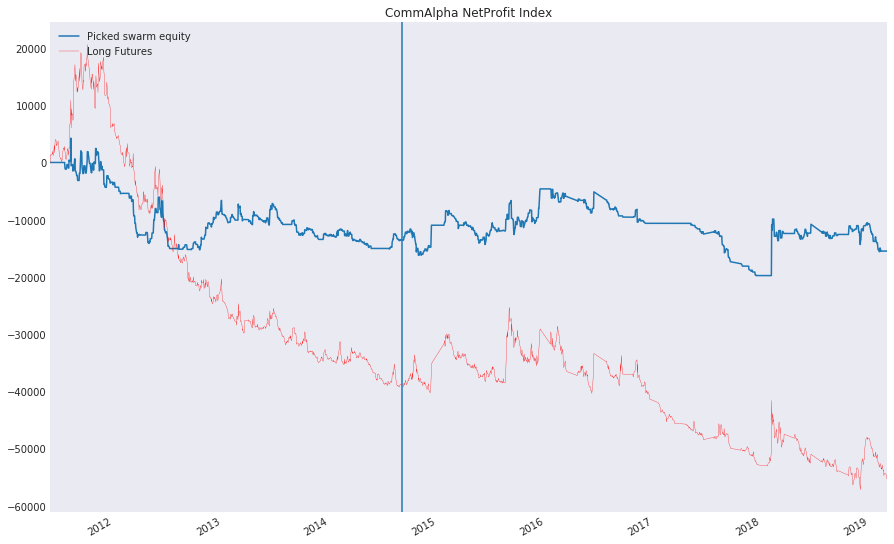

In [17]:
figsize(15,10)
smgr.picked_equity.tail(3100).plot(label='Picked swarm equity',title= "CommAlpha NetProfit Index");
# smgr.raw_equity.plot(label='Average swarm equity');
(smgr.strategy.data.exo*1).plot(label='Long Futures',linewidth=0.3, color='red')
axvline(last_opt_date)
legend(loc=2);

In [ ]:
import bt
data = bt.merge(smgr.picked_equity,smgr.picked_delta)
data.to_csv('DSP_VX_L_3_w_deltas.csv')
data_equity = bt.merge(smgr.picked_equity)
data_equity.to_csv('DSP_VX_L_3.csv')

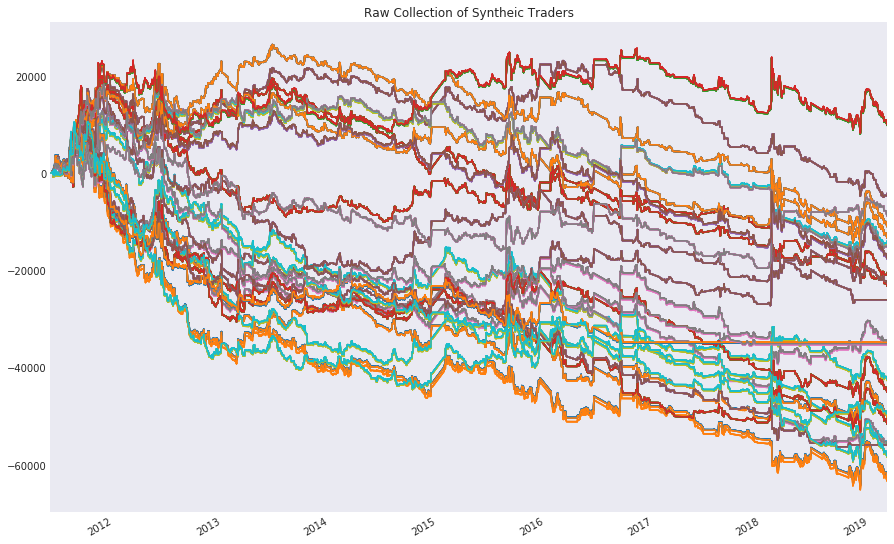

In [18]:
smgr.raw_swarm.plot(legend=False,title= "Raw Collection of Syntheic Traders");